# Principal component analysis (PCA)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.manifold import TSNE

def load_and_preprocess_data(filepath):
    data = np.loadtxt(filepath)
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def perform_pca(X):
    cov_matrix = np.cov(X.T)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Transform the data
    transformed_data = X @ eigenvectors
    
    return eigenvalues, eigenvectors, transformed_data

def plot_2d_projection(transformed_data, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

def create_dimension_reduction_plots(X):
    # PCA
    _, _, pca_transformed = perform_pca(X)
    plot_2d_projection(pca_transformed[:, :2], 'PCA Projection')
    
    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_embedding = reducer.fit_transform(X)
    plot_2d_projection(umap_embedding, 'UMAP Projection')
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embedding = tsne.fit_transform(X)
    plot_2d_projection(tsne_embedding, 't-SNE Projection')

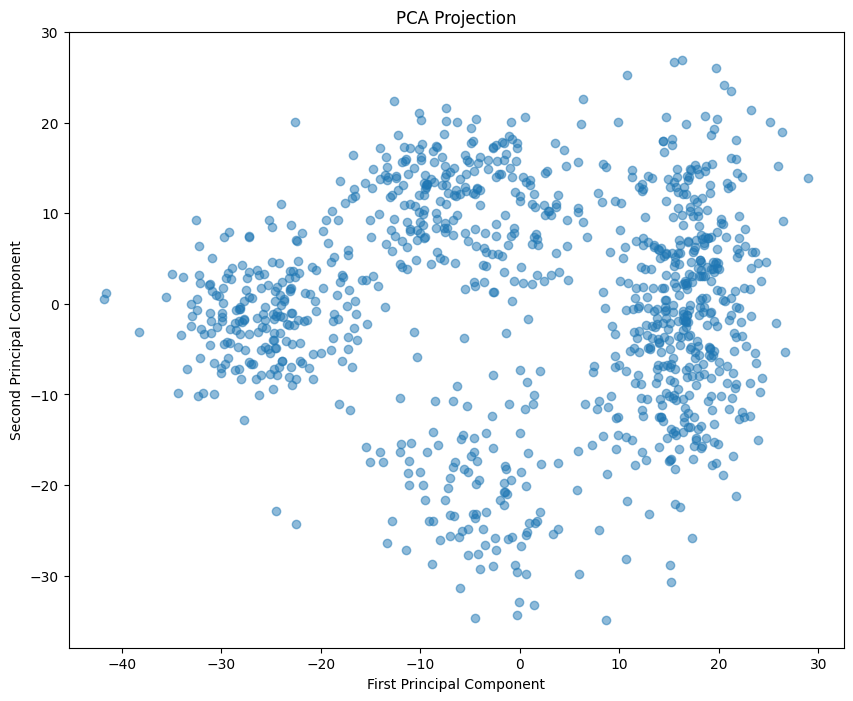

e:\L-4 T-2\CSE-472(ML)\Offline 4\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


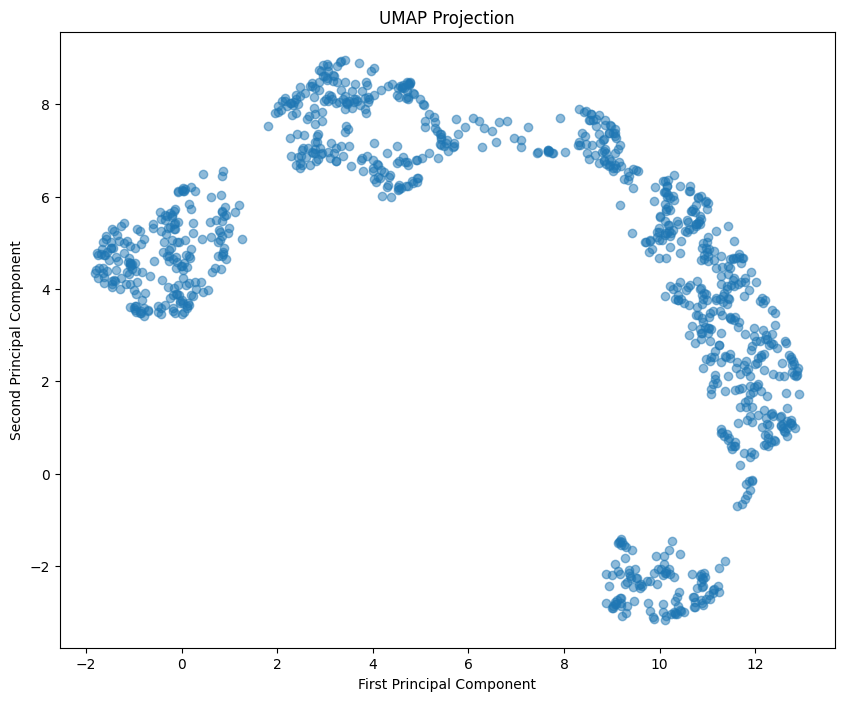

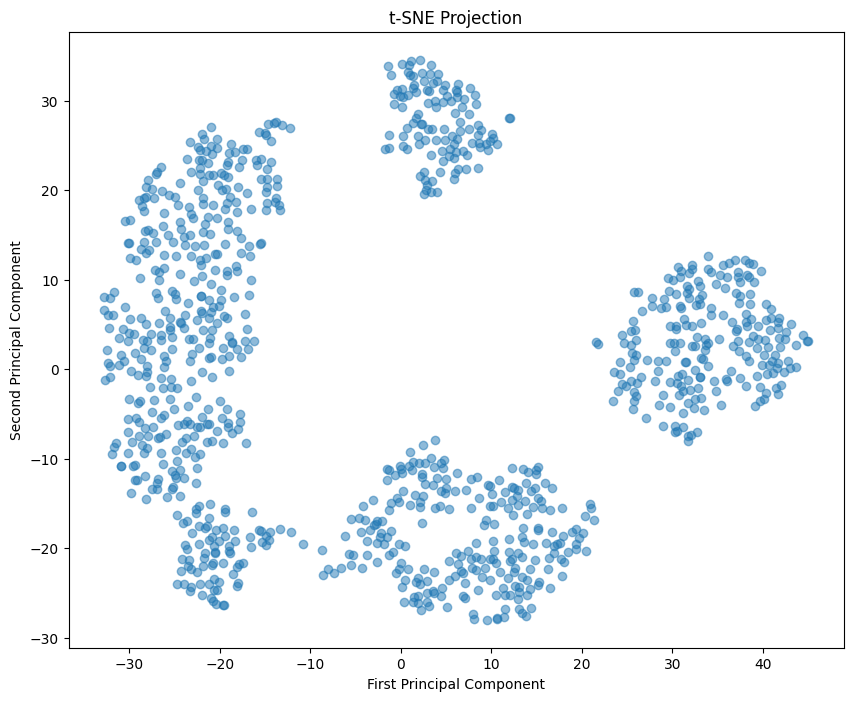

In [7]:
# Load and process data
data = load_and_preprocess_data("pca_data.txt")

# Create all dimensionality reduction plots
create_dimension_reduction_plots(data)

# Expectation-maximization (EM) algorithm

In [8]:
import numpy as np
from scipy.special import logsumexp, gammaln
import matplotlib.pyplot as plt
from scipy.stats import poisson

class PoissonMixtureEM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        # Store training history
        self.history = {
            'means': [],
            'iterations': []
        }
        
    def _initialize_parameters(self, X):
        self.weights_ = np.ones(self.n_components) / self.n_components
        data_mean = np.mean(X)
        self.means_ = np.array([0.7 * data_mean, 1.3 * data_mean])
        
    def _plot_final_fit(self, X):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: Final mixture model fit
        ax1.hist(X, bins=range(int(max(X))+2), density=True, alpha=0.5, 
                label='Observed Data', color='gray')
        
        x = np.arange(0, int(max(X))+1)
        mixture = np.zeros_like(x, dtype=float)
        
        colors = ['blue', 'red']
        for k in range(self.n_components):
            component = self.weights_[k] * poisson.pmf(x, self.means_[k])
            mixture += component
            ax1.plot(x, component, '--', color=colors[k], alpha=0.7,
                    label=f'Component {k+1} (λ={self.means_[k]:.2f}, π={self.weights_[k]:.2f})')
        
        ax1.plot(x, mixture, 'k-', linewidth=2, label='Final Mixture')
        ax1.set_title('Poisson Mixture Model Fit')
        ax1.set_xlabel('Number of Children')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Means convergence
        means_history = np.array(self.history['means'])
        iterations = self.history['iterations']
        
        ax2.plot(iterations, means_history[:, 0], 'b-', linewidth=2, 
                label='Mean λ₁ (Family Planning)')
        ax2.plot(iterations, means_history[:, 1], 'r-', linewidth=2, 
                label='Mean λ₂ (No Family Planning)')
        
        ax2.set_title('Convergence of Poisson Means')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Mean Value (λ)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    def _e_step(self, X):
        """Expectation step: compute responsibilities."""
        log_resp = np.zeros((len(X), self.n_components))
        
        for k in range(self.n_components):
            log_resp[:, k] = (X * np.log(self.means_[k]) - self.means_[k] - 
                            gammaln(X + 1)) + np.log(self.weights_[k])
        
        log_norm = logsumexp(log_resp, axis=1, keepdims=True)
        log_resp -= log_norm
        return np.exp(log_resp)
    
    def _m_step(self, X, resp):
        """Maximization step: update parameters."""
        self.weights_ = resp.mean(axis=0)
        
        for k in range(self.n_components):
            self.means_[k] = np.sum(resp[:, k] * X) / np.sum(resp[:, k])
    
    def fit(self, X):
        """Fit the Poisson mixture model using EM."""
        self._initialize_parameters(X)
        
        # Store initial parameters
        self.history['means'].append(self.means_.copy())
        self.history['iterations'].append(0)
        
        for iteration in range(self.max_iter):
            # E-step
            resp = self._e_step(X)
            
            # Store current parameters
            old_means = self.means_.copy()
            old_weights = self.weights_.copy()
            
            # M-step
            self._m_step(X, resp)
            
            # Store parameters
            self.history['means'].append(self.means_.copy())
            self.history['iterations'].append(iteration + 1)
            
            # Check convergence
            mean_change = np.max(np.abs(self.means_ - old_means))
            weight_change = np.max(np.abs(self.weights_ - old_weights))
            
            if mean_change < self.tol and weight_change < self.tol:
                print(f"Converged after {iteration+1} iterations")
                break
        
        # Plot final results
        self._plot_final_fit(X)
        return self

In [9]:
def analyze_family_planning_data(filepath):
    data = np.loadtxt(filepath)
    
    model = PoissonMixtureEM()
    model.fit(data)
    
    # Sort results by mean number of children
    idx = np.argsort(model.means_)
    sorted_means = model.means_[idx]
    sorted_weights = model.weights_[idx]
    
    print("\nResults of Family Planning Analysis:")
    print("=====================================")
    print(f"Group with family planning advice:")
    print(f"- Mean number of children: {sorted_means[0]:.2f}")
    print(f"- Proportion of families: {sorted_weights[0]:.2%}")
    print(f"\nGroup without family planning advice:")
    print(f"- Mean number of children: {sorted_means[1]:.2f}")
    print(f"- Proportion of families: {sorted_weights[1]:.2%}")
    
    return model

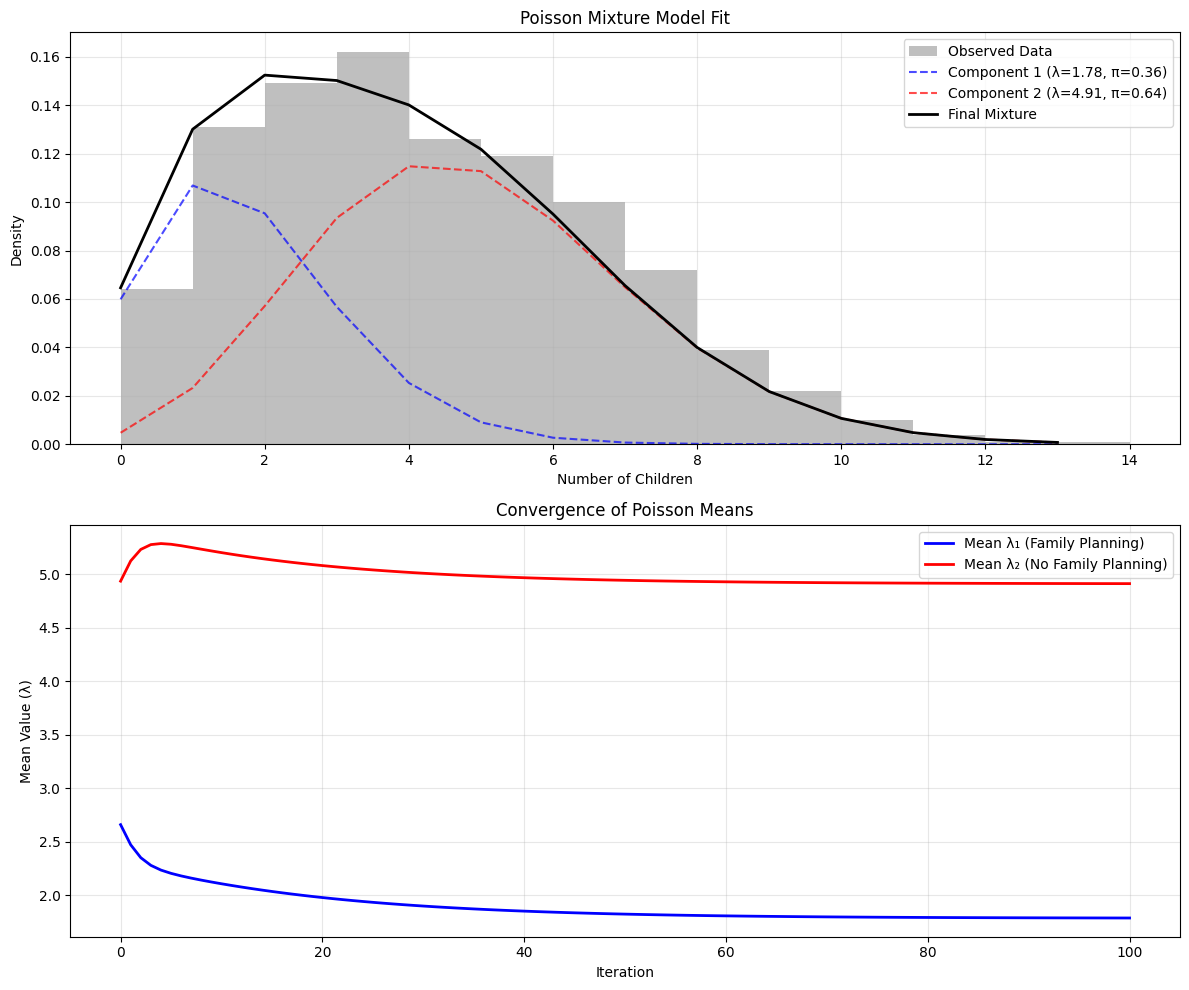


Results of Family Planning Analysis:
Group with family planning advice:
- Mean number of children: 1.78
- Proportion of families: 35.67%

Group without family planning advice:
- Mean number of children: 4.91
- Proportion of families: 64.33%


In [10]:
model = analyze_family_planning_data("em_data.txt")